In [2]:
#import midi_functions
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import callbacks
from keras import optimizers

from IPython.display import clear_output
import matplotlib.pyplot as plt



#import pydot as pyd
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [3]:
input_length = 10
X = np.loadtxt('10X.txt')
Y = np.loadtxt('10Y.txt')

n = len(X)
permutation = np.random.permutation(n)
X = X[permutation]
Y = Y[permutation]

sorted_notes = np.copy(Y)
sorted_notes.sort()
sorted_notes = np.unique(sorted_notes)

number_of_different_notes = len(sorted_notes)
max_note = np.max(Y)
min_note = np.min(Y)

X = X / max_note #normalize input

for i,note in enumerate(Y): #make all the notes a number between 0 and number_of_different_notes
    Y[i] = np.where(sorted_notes == note)[0]
Y = np_utils.to_categorical(Y)

print('Number of different notes: {}'.format(number_of_different_notes))
print('Shape of X: {}'.format(X.shape))
print('Max: {}, Min: {}'.format(int(max_note), int(min_note)))

n = X.shape[0]

Number of different notes: 85
Shape of X: (318594, 10)
Max: 107, Min: 21


In [6]:
n_hidden_units = number_of_different_notes #this should probably be the number of different notes since it is also the output of softmax

model = Sequential()
model.add(LSTM(
    256,
    input_shape=((input_length,1)),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(n_hidden_units, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(n_hidden_units))
model.add(Activation('softmax'))
rmsprop = optimizers.RMSprop(lr=0.002, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
# Load the weights to each node
#model.load_weights('./weights/2LSTM-200-0.3503.hdf5')


#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
print(model.summary())
#print(model.get_weights())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10, 256)           264192    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 85)                116280    
_________________________________________________________________
dropout_2 (Dropout)          (None, 85)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 85)                7310      
_________________________________________________________________
activation_3 (Activation)    (None, 85)                0         
Total params: 387,782
Train

In [7]:
class live_plot(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.index = 0
        self.epochs = []
        
        self.losses = []
        self.val_losses = []
        
        self.acc = []
        self.val_acc = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.epochs.append(self.index)
        
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs['val_acc'])
        self.index += 1
        
        clear_output(wait=True)
        plt.plot(self.epochs, self.losses, label="loss")
        plt.plot(self.epochs, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
        plt.plot(self.epochs, self.acc, label="acc")
        plt.plot(self.epochs, self.val_acc, label="val_acc")
        plt.legend()
        plt.show();

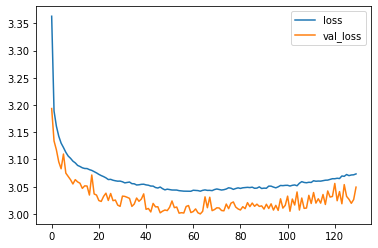

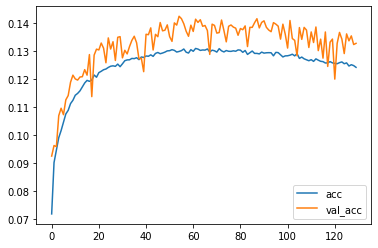

Epoch 131/400
189632/254875 [=====================>........] - ETA: 31s - loss: 3.0738 - acc: 0.1228

KeyboardInterrupt: 

In [8]:
filepath = "./weights/2LSTM-{epoch:02d}-{loss:.4f}.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)

plot = live_plot()

callbacks_list = [checkpoint, plot]     
fit_data = model.fit(X.reshape(n, input_length, 1), Y, validation_split=0.20,epochs=400, batch_size=64, callbacks=callbacks_list)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


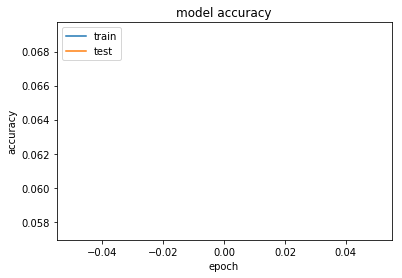

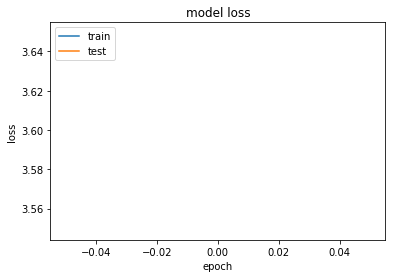

In [20]:
print(fit_data.history.keys())
# summarize history for accuracy
plt.plot(fit_data.history['acc'])
plt.plot(fit_data.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(fit_data.history['loss'])
plt.plot(fit_data.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [4]:
#Generate 200 notes

#random sequence to initialize predictions
init = X[np.random.randint(0,len(X))]

predicted_notes = np.zeros(200 + input_length)
predicted_notes[0:input_length] = init

for note_index in range(200):
    x = predicted_notes[note_index:note_index + input_length]
    #print('Input: {}'.format(x))
    prediction = model.predict(x.reshape(1,10,1))
    #print('Prediction: {}'.format(np.argmax(prediction)))
    predicted_notes[note_index + input_length] = sorted_notes[np.argmax(prediction)] / max_note
predicted_notes = predicted_notes * max_note

In [5]:
predicted_notes

array([67., 68., 56., 55., 68., 56., 46., 68., 74., 58., 75., 74., 72.,
       70., 50., 68., 67., 53., 66., 55., 67., 69., 55., 69., 63., 60.,
       66., 56., 68., 65., 60., 65., 62., 63., 60., 60., 60., 60., 53.,
       59., 59., 60., 60., 50., 59., 57., 55., 57., 59., 55., 59., 48.,
       60., 51., 55., 57., 55., 55., 53., 56., 50., 53., 52., 53., 59.,
       50., 55., 55., 55., 53., 53., 56., 55., 53., 53., 56., 53., 55.,
       56., 55., 53., 51., 51., 53., 53., 52., 48., 48., 64., 57., 56.,
       58., 62., 55., 67., 56., 63., 67., 62., 62., 69., 60., 65., 63.,
       60., 65., 65., 60., 50., 64., 59., 61., 51., 59., 59., 67., 57.,
       59., 63., 64., 62., 59., 59., 60., 60., 57., 59., 59., 62., 60.,
       60., 62., 59., 59., 55., 60., 59., 60., 60., 59., 60., 60., 55.,
       60., 55., 57., 60., 59., 59., 60., 60., 60., 55., 56., 55., 57.,
       60., 53., 58., 53., 59., 55., 60., 57., 57., 60., 55., 60., 58.,
       62., 60., 60., 60., 60., 57., 55., 55., 57., 59., 43., 50

In [7]:
midi_functions.create_midi_from_notes(predicted_notes, on=250)